# Showcasing the interface between NEST, Elephant and Viziphant

Based on material provided by Elephant Developers

- Analysis and visualization tools developed at INM-6, Jülich Research Centre (Sonja Grün, Michael Denker)
- https://elephant.readthedocs.io/en/latest/
- https://viziphant.readthedocs.io/en/latest/
- Work best with data on file

**NB: Switch to `EBRAINS-23.09` kernel in top left before proceeding!**

**NB: I never completed the revision of this tutorial and did not hold it at LASCON IX due to time constraints.**

In [2]:
%matplotlib inline

## Simulate the Brunel Model

This script simulates an excitatory and an inhibitory population on
the basis of Brunel N (2000), *Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons*, Journal of Computational Neuroscience **8**:183-208.

In [ ]:
import nest

In [56]:
def brunel_sim(g, eta, label, conn_rule=None):
    nest.set_verbosity('M_WARNING')
    nest.ResetKernel()
    
    dt = 0.1  # the resolution in ms
    simtime = 2000.0  # Simulation time in ms /2000
    delay = 1.5  # synaptic delay in ms
    
    order = 2500
    NE = 4 * order  # number of excitatory neurons
    NI = 1 * order  # number of inhibitory neurons
    N_neurons = NE + NI  # number of neurons in total
    N_rec = 50  # record from 50 neurons
    
    epsilon = 0.1  # connection probability
    CE = int(epsilon * NE)  # number of excitatory synapses per neuron
    CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
    C_tot = CI + CE  # total number of synapses per neuron
    
    tauMem = 20.0  # time constant of membrane potential in ms
    theta = 20.0  # membrane threshold potential in mV
    neuron_params = {"C_m": 1.0,
                     "tau_m": tauMem,
                     "t_ref": 2.0,
                     "E_L": 0.0,
                     "V_reset": 0.0,
                     "V_m": 0.0,
                     "V_th": theta}
    J = 0.1  # postsynaptic amplitude in mV
    J_ex = J  # amplitude of excitatory postsynaptic potential
    J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential
    
    nu_th = theta / (J * CE * tauMem)
    nu_ex = eta * nu_th
    p_rate = 1000.0 * nu_ex * CE
    
    nest.resolution = dt
    nest.overwrite_files = True

    # Create neurons and devices
    nodes_ex = nest.Create("iaf_psc_delta", NE, params=neuron_params)
    nodes_in = nest.Create("iaf_psc_delta", NI, params=neuron_params)
    noise = nest.Create("poisson_generator", params={"rate": p_rate})
    espikes = nest.Create("spike_recorder", 
                          params={"label": f"data/{label}-brunel-ex", "record_to": "ascii", "file_extension": "gdf"})
    ispikes = nest.Create("spike_recorder", 
                          params={"label": f"data/{label}-brunel-in", "record_to": "ascii", "file_extension": "gdf"})

    # Connect neurons
    syn_params_ex = {"synapse_model": "static_synapse", "weight": J_ex, "delay": delay}
    syn_params_in = {"synapse_model": "static_synapse", "weight": J_in, "delay": delay}

    if conn_rule is None or conn_rule == "fixed_indegree":
        conn_params_ex = {"rule": "fixed_indegree", "indegree": CE}
        conn_params_in = {"rule": "fixed_indegree", "indegree": CI}
    elif conn_rule == "fixed_outdegree":
        conn_params_ex = {"rule": "fixed_outdegree", "outdegree": CE}
        conn_params_in = {"rule": "fixed_outdegree", "outdegree": CI}
    elif conn_rule == "pairwise_bernoulli":
        conn_params_ex = {"rule": "pairwise_bernoulli", "p": epsilon}
        conn_params_in = {"rule": "pairwise_bernoulli", "p": epsilon}
    elif conn_rule == "fixed_total_number":
        conn_params_ex = {"rule": "fixed_total_number", "N": N_E * C_E}
        conn_params_in = {"rule": "fixed_total_number", "N": N_I * C_I}
        
    nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, syn_params_ex)
    nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, syn_params_in)
    
    # Connect devices
    nest.Connect(noise, nodes_ex + nodes_in, syn_spec=syn_params_ex)
    nest.Connect(nodes_ex[:N_rec], espikes)
    nest.Connect(nodes_in[:N_rec], ispikes)

    nest.Simulate(simtime)
    
    print(f"Number of network nodes: {nest.network_size}")
    print(f"          connections  : {nest.num_connections}")
    print(f"          spikes       : {nest.local_spike_counter}")    

In [57]:
!mkdir -p data

In [58]:
brunel_sim(g=3, eta=2, label='A')
brunel_sim(g=6, eta=4, label='B')
brunel_sim(g=5, eta=2, label='C')
brunel_sim(g=4.5, eta=0.9, label='D')

Number of network nodes: 2503
          connections  : 627600
          spikes       : 386456
Number of network nodes: 2503
          connections  : 627600
          spikes       : 499340
Number of network nodes: 2503
          connections  : 627600
          spikes       : 264316
Number of network nodes: 2503
          connections  : 627600
          spikes       : 20080


## Processing NEST data with Elephant

In the following we load the simulation data generated with NEST and perform anaysis with Elephant (Electrophysiology Analysis Toolkit).

---
### Hotfix: Delete descriptive meta-data header prior to data

Until the IO for NEST in Neo is updated, the following hotfix is applied to the `.gdf`-files to remove the GDF file header
(*once Neo is updated, simply remove* `'no_header_'`)

In [59]:
from pathlib import Path
for fn in Path("data").glob("*.gdf"):
    orig = open(fn, "r").readlines()
    open(fn, "w").write(''.join(orig[3:]))

### Load simulation data 

In this example the data resulting from the NEST simulation, the `.gdf` files (after pre-processing above) are loaded using the nestIO from **Neo** package.

```
10	13.400
3	14.200
4	14.800
6	14.700
7	14.900
9	15.000
11	14.300
12	13.800
13	14.600
15	14.900
16	14.300
27	14.800
```

See also
- https://neo.readthedocs.io/en/latest/read_and_analyze.html
- https://neo.readthedocs.io/en/latest/iolist.html#neo.io.NestIO

We load only the excitatory data here

In [60]:
from neo.io.nestio import NestIO
import quantities as pq

spike_data = {}

for case in ['A', 'B', 'C', 'D']:
    IO = NestIO(next(Path('data').glob(f'{case}-brunel-ex-*-0.gdf')).as_posix())
    spike_data[case] = IO.read_segment(gid_list=[], # empty list to retrieve spiketrains from all neurons
                                       t_start=0 * pq.ms,
                                       t_stop=2000 * pq.ms,
                                       id_column_gdf=0,  # column 0 contains the neuron ID
                                       time_column_gdf=1, # column 1 contains the times in ms
                                      )

### Visualize simulation data

The following example makes use of Viziphants `eventplot` function to get an overview of the simuation results.

See also: https://viziphant.readthedocs.io/en/latest/toctree/rasterplot/viziphant.rasterplot.eventplot.html#viziphant.rasterplot.eventplot

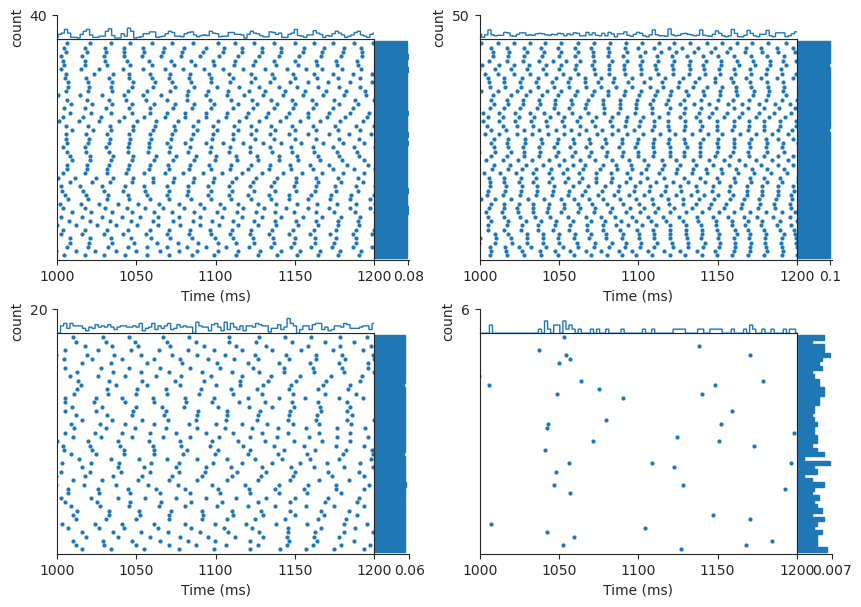

In [78]:
from viziphant.rasterplot import eventplot, rasterplot_rates
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf, gca

for idx, (case, trains) in enumerate(spike_data.items()):
    ax = plt.subplot(2, 2, idx + 1)
    ax, axx, _ = rasterplot_rates(trains.spiketrains, pophistbins=1000, ax=ax)
    ax.set_xlim(1000, 1200)
    axx.set_xlim(1000, 1200)
    #ax.set_ylim(-1, 50)
    ax.set_title(case)

fig=gcf()
fig.set_size_inches(10, 7)

The following descriptions for A, B, C, and D are taken from [1]: 

- A: Almost fully synchronized network, neurons firing regularly at high rates
- B: Fast oscillation of the global activity, neurons firing irregularly at a rate that is lower than the global frequency
- C: Stationary global activity, irregularly firing neurons
- D: Slow oscillation of the global activity, neurons firing irregularly at very low rates

How do those results compare to the results in Fig. 8 of Brunel (2000)?

### Coefficient of Variation (CV)
In this section we will have a look at the coefficient of variation (CV), a measure of the variability of inter-spike intervals. A spike train that is modeled as a random (stochastic) Poisson process has a CV of 1.

To calculate the distribution of the CVs obtained from inter-spike intervals (ISIs) of the simulated spike trains, we do the following:

- For each spike train, we first call elephants' `isi()` function which returns an array of all N-1 ISIs for the N spikes in the input spike train. 
- We then feed the list of ISIs into the `cv()` function, which returns a single value for the coefficient of variation.

See also:
- `isi()`: https://elephant.readthedocs.io/en/latest/reference/_toctree/statistics/elephant.statistics.isi.html#elephant.statistics.isi
- `cv()`: https://elephant.readthedocs.io/en/latest/reference/_toctree/statistics/elephant.statistics.cv.html#elephant.statistics.cv

In [80]:
from elephant.statistics import isi, cv

# calculate inter-spike intervals for the first spike train
print(isi(spike_data['A'].spiketrains[0])[1:10]) 

[13.4 14.4 13.7 13.7 11.6 12.5 13.8 11.2 13. ] ms


#### ISI histograms

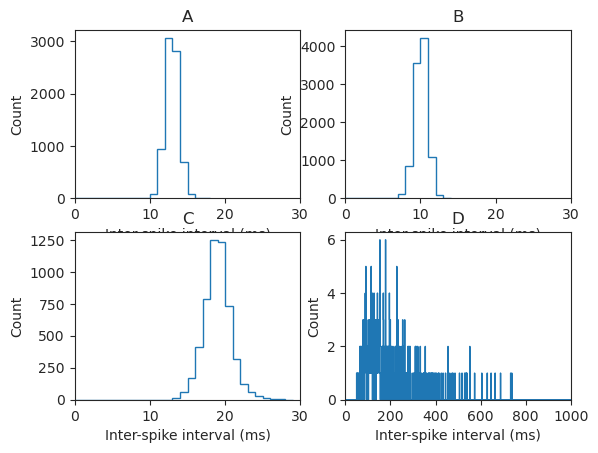

In [86]:
from viziphant.statistics import plot_isi_histogram

for idx, (case, trains) in enumerate(spike_data.items()):
    ax = plt.subplot(2, 2, idx + 1)
    plot_isi_histogram([trains.spiketrains], axes=ax, title=case, bin_size=1*pq.ms)
    ax.set_xlim(0, 30 if idx < 3 else 1000)

#### CV histograms 

In the follwoing we create a histogram of the CVs for all cases (A, B, C and D).

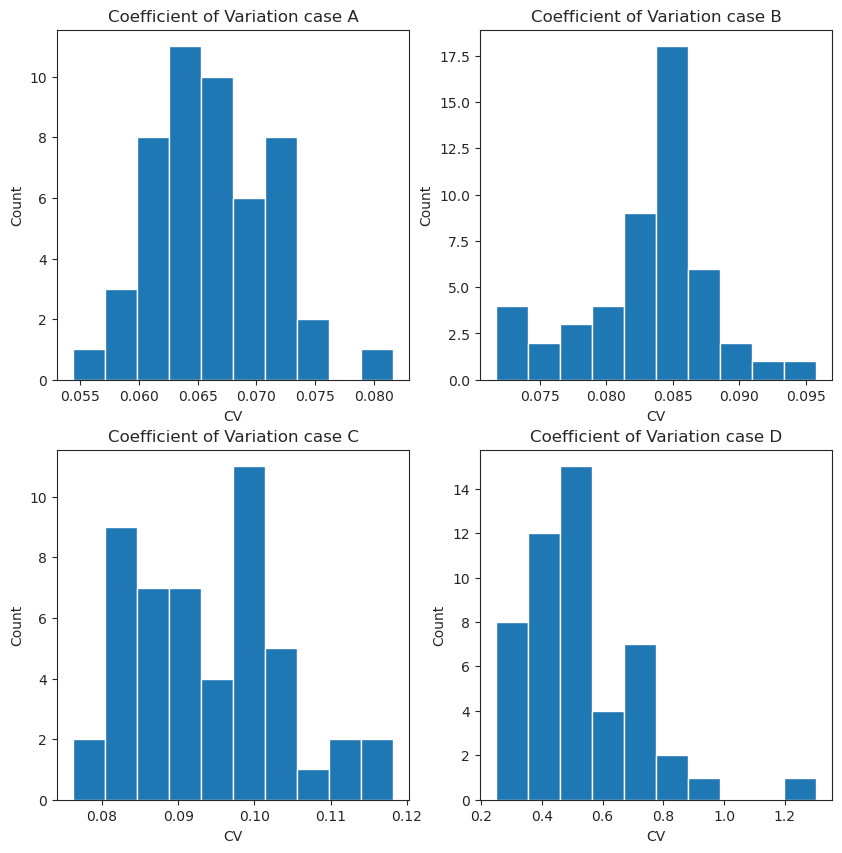

In [88]:
for idx, (case, trains) in enumerate(spike_data.items()):
    cv_list = [cv(isi(train)) for train in trains.spiketrains]
    ax = plt.subplot(2, 2, idx + 1)
    plt.hist(cv_list)
    #plt.xlim(0, 1)
    #plt.ylim(0, 20)
    plt.xlabel('CV')
    plt.ylabel('Count')
    plt.title(f'Coefficient of Variation case {case}')

fig=gcf()
fig.set_size_inches(10,10)

### 1.4 Cross-correlation

Lets assess if there are correlations between the spike trains.

To investigate that, Elephant provides functions to calculate and plot the cross-correlation matrix. This matrix quantifies the similarity for each pair of spike trains in the trial. 

**Binning**

We start by binning the spike trains. Let's use a bin size of 3 ms. With this, we are obtaining the number of spikes that occurred during small intervals.

See also:
- BinnedSpikeTrain: https://elephant.readthedocs.io/en/latest/reference/_toctree/conversion/elephant.conversion.BinnedSpikeTrain.html#elephant.conversion.BinnedSpikeTrain

In [25]:
from elephant import conversion
binned_spiketrains_A = conversion.BinnedSpikeTrain(
                                                segment_A.spiketrains, 
                                                binsize=3*pq.ms
                                                )
print("Total number of bins: "+str(binned_spiketrains_A.n_bins))

Total number of bins: 666


/srv/main-spack-instance-2302/spack/var/spack/environments/ebrains-23-02/.spack-env/view/lib/python3.8/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 23 last spike(s) of the input spiketrain


If we inspect the spike times of one neuron, we can see that if the neuron fired in a particular bin,
the `BinnedSpikeTrain` object will store the value 1.

In [26]:
print("Timepoints in ms where spike occured")
spiketrain_id=0
print(segment_A.spiketrains[spiketrain_id][0:8])
print("Timepoints in ms of bin edges")
print(binned_spiketrains_A[spiketrain_id].bin_edges[0:20])
print("Binned spiketrain")
print(binned_spiketrains_A[spiketrain_id].to_array()[0,0:20])

Timepoints in ms where spike occured
[13.9 18.1 24.7 30.4 35.5 40.9 45.8 51.1] ms
Timepoints in ms of bin edges
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30. 33. 36. 39. 42. 45. 48. 51.
 54. 57.] ms
Binned spiketrain
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1]


**cross-correlation matrix**

Then we calculate the cross-correlation matrix of the binned spikes using the `correlation_coefficient`
function from the `spike_train_correlation` module.

See also: https://elephant.readthedocs.io/en/latest/reference/_toctree/spike_train_correlation/elephant.spike_train_correlation.correlation_coefficient.html#elephant.spike_train_correlation.correlation_coefficient

In [27]:
from elephant import spike_train_correlation
cross_corr_matrix_A = spike_train_correlation.correlation_coefficient(binned_spiketrains_A)

Calculate the cross-correlation for the other cases.

In [28]:
# Case B
binned_spiketrains_B = conversion.BinnedSpikeTrain( # binning
                                                segment_B.spiketrains, 
                                                binsize=3*pq.ms
                                                )
cross_corr_matrix_B = spike_train_correlation.correlation_coefficient(binned_spiketrains_B) # calculate the cross-correlation matrix
# Case C
binned_spiketrains_C = conversion.BinnedSpikeTrain( # binning
                                                segment_C.spiketrains, 
                                                binsize=3*pq.ms
                                                )
cross_corr_matrix_C = spike_train_correlation.correlation_coefficient(binned_spiketrains_C) # calculate the cross-correlation matrix
# Case D
binned_spiketrains_D = conversion.BinnedSpikeTrain( # binning
                                                segment_D.spiketrains, 
                                                binsize=3*pq.ms
                                                )
cross_corr_matrix_D = spike_train_correlation.correlation_coefficient(binned_spiketrains_D) # calculate the cross-correlation matrix

/srv/main-spack-instance-2302/spack/var/spack/environments/ebrains-23-02/.spack-env/view/lib/python3.8/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/srv/main-spack-instance-2302/spack/var/spack/environments/ebrains-23-02/.spack-env/view/lib/python3.8/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain


### Viziphant
We visualize the matrix using the `plot_corrcoef` function of Viziphant. To compare the coefficients, we will set correlation_range to fixed values, to use the color bar only in the same range for all cases. We will also not plot the values along the main diagonal, as those are equal to 1, by setting remove_diagonal to True.

See also: https://viziphant.readthedocs.io/en/latest/toctree/spike_train_correlation/viziphant.spike_train_correlation.plot_corrcoef.html#viziphant.spike_train_correlation.plot_corrcoef

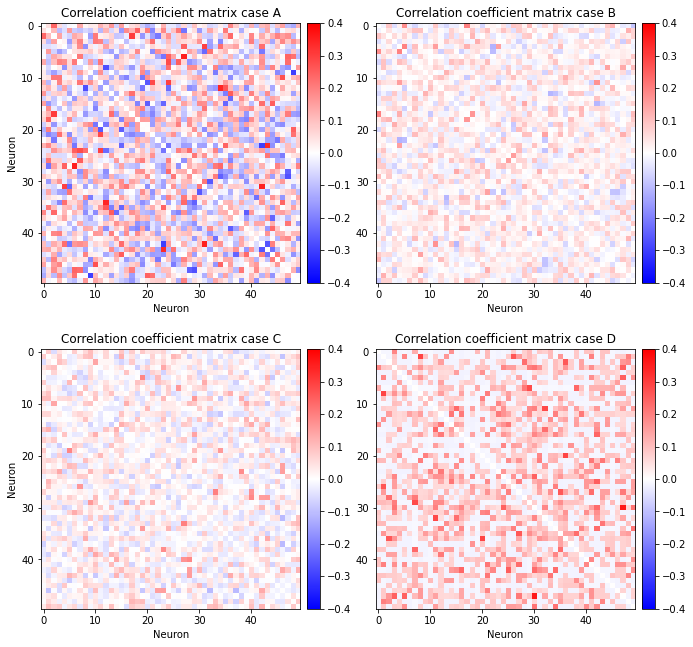

In [29]:
from viziphant.spike_train_correlation import plot_corrcoef
correlation_range=(-0.4,0.4)

plt.subplot(2, 2, 1)
axes=plot_corrcoef(cross_corr_matrix_A, axes=gca(), correlation_range=correlation_range,remove_diagonal=True)
axes.set_xlabel('Neuron')
axes.set_ylabel('Neuron')
axes.set_title("Correlation coefficient matrix case A");

plt.subplot(2, 2, 2)
axes=plot_corrcoef(cross_corr_matrix_B, axes=gca(), correlation_range=correlation_range,remove_diagonal=True)
axes.set_xlabel('Neuron')
axes.set_title("Correlation coefficient matrix case B");

plt.subplot(2, 2, 3)
axes=plot_corrcoef(cross_corr_matrix_C, axes=gca(), correlation_range=correlation_range,remove_diagonal=True)
axes.set_xlabel('Neuron')
axes.set_ylabel('Neuron')
axes.set_title("Correlation coefficient matrix case C");

plt.subplot(2, 2, 4)
axes=plot_corrcoef(cross_corr_matrix_D, axes=gca(), correlation_range=correlation_range,remove_diagonal=True)
axes.set_xlabel('Neuron')
axes.set_title("Correlation coefficient matrix case D");

fig=gcf()
fig.set_size_inches(11,11)

### 1.5 Spike train distance Victor-Purpura’s (VP) distance

Lets investigate the similarity of the spike trains.

To investigate that, Elephant provides different spike train similarity measures. In this case we will use the Victor-Purpura distance.

See also: https://elephant.readthedocs.io/en/latest/reference/_toctree/spike_train_dissimilarity/elephant.spike_train_dissimilarity.victor_purpura_distance.html

In [30]:
from elephant.spike_train_dissimilarity import victor_purpura_distance
pairwise_vp_distance_A = victor_purpura_distance(segment_A.spiketrains)

In [31]:
pairwise_vp_distance_B = victor_purpura_distance(segment_B.spiketrains)
pairwise_vp_distance_C = victor_purpura_distance(segment_C.spiketrains)
pairwise_vp_distance_D = victor_purpura_distance(segment_D.spiketrains)

Create plots with a colorbar for all cases.

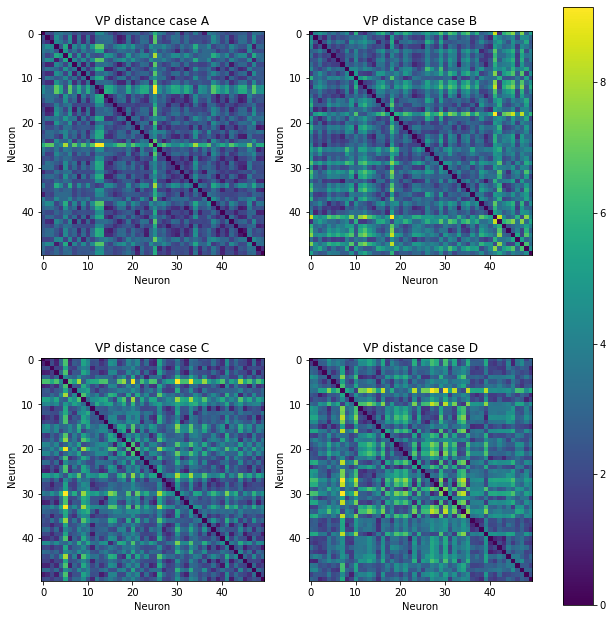

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2)
im=axes.flat[0].imshow(pairwise_vp_distance_A)
axes.flat[0].set_xlabel('Neuron')
axes.flat[0].set_ylabel('Neuron')
axes.flat[0].set_title("VP distance case A")

im=axes.flat[1].imshow(pairwise_vp_distance_B)
axes.flat[1].set_xlabel('Neuron')
axes.flat[1].set_ylabel('Neuron')
axes.flat[1].set_title("VP distance case B")

im=axes.flat[2].imshow(pairwise_vp_distance_C)
axes.flat[2].set_xlabel('Neuron')
axes.flat[2].set_ylabel('Neuron')
axes.flat[2].set_title("VP distance case C")

im=axes.flat[3].imshow(pairwise_vp_distance_D)
axes.flat[3].set_xlabel('Neuron')
axes.flat[3].set_ylabel('Neuron')
axes.flat[3].set_title("VP distance case D")

plt.colorbar(im, ax=axes.ravel().tolist()) # add colorbar

fig=gcf()
fig.set_size_inches(11,11)

In [33]:
# clear up working directory: remove simulation results
!rm -f A-brunel-py-ex-2502-0.gdf
!rm -f A-brunel-py-in-2503-0.gdf